In [2]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
#from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
r = pd.read_pickle("sample.pickle")

def split_data(df, test_size=0.3):
    sorted_id_list = df.sort_values("date").index.unique()
    train_id_list = sorted_id_list[: round(len(sorted_id_list) * (1 - test_size))]
    test_id_list = sorted_id_list[round(len(sorted_id_list) * (1 - test_size)) :]
    train = df.loc[train_id_list]#.drop(['date'], axis=1)
    test = df.loc[test_id_list]#.drop(['date'], axis=1)
    return train, test

In [ ]:
from typing import Dict, Optional
from collections import OrderedDict
from tensorflow import keras
from tqdm.auto import tqdm

class KerasProgressBarCallback(keras.callbacks.Callback):
    description: Optional[str]
    pbar_epoch: tqdm
    pbar_step: tqdm

    def __init__(self, description: Optional[str] = None):
        self.description = description
        self.pbar_epoch = tqdm(desc=self.description)
        self.pbar_step = tqdm(desc="steps")

    def __update_postfix(self, pbar: tqdm, logs: Dict[str, float]):
        postfix = OrderedDict([(key, str(value)) for key, value in logs.items()])
        pbar.set_postfix(ordered_dict=postfix, refresh=False)

    def on_train_begin(self, logs={}):
        total_epoch = self.params.get("epochs")
        total_step = self.params.get("steps")
        self.pbar_epoch.reset(total=total_epoch)
        self.pbar_step.reset(total=total_step)

    def on_train_end(self, logs={}):
        self.pbar_epoch.close()
        self.pbar_step.close()

    def on_epoch_begin(self, epoch, logs={}):
        self.pbar_step.reset()

    def on_epoch_end(self, epoch, logs={}):
        self.__update_postfix(self.pbar_epoch, logs)
        self.pbar_epoch.update(1)

    def on_batch_end(self, step, logs={}):
        self.__update_postfix(self.pbar_step, logs)
        self.pbar_step.update(1)
        
model.fit(
    x_train,
    y_train,
    validation_data=(x_valid, y_valid),
    epochs=100,
    batch_size=2048,
    callbacks=[KerasProgressBarCallback(description="MLP")],
    verbose=0,
)

In [140]:
#r = r.fillna(0).astype(int)

train, valid = split_data(r)
train, test = split_data(train)

In [139]:
print("train .{}".format(train.shape),\
     "test .{}".format(test.shape),\
     "valid .{}".format(valid.shape))

train .(23419, 180) test .(13991, 180) valid .(9708, 180)


In [352]:
#NNようのデータ制作　引数に前処理されたデータを入力することでNN用のデータ分割、処理を行う
class NN_data():
    from tensorflow import keras
    def __init__(self, data, rank=False):
        train, test = split_data(data)
        train, valid = split_data(train)

        if rank == True:
            X_train = train.drop(["rank","ranking","単勝","second","着順","rls","data","date"], axis=1)
            X_train = X_train.fillna(0).astype(int)
            y_train = train["rank"] # 1or0

            X_test = test.drop(["rank","ranking","単勝","second","着順","rls","data","date"], axis=1)
            X_test = X_test.fillna(0).astype(int)
            y_test = test["rank"]

            X_valid = valid.drop(["rank","ranking","単勝","second","着順","rls","data","date"], axis=1)
            X_valid = X_valid.fillna(0).astype(int)
            y_valid = valid["rank"]

            self.X_train = X_train
            self.y_train = y_train
            self.X_test = X_test
            self.y_test = y_test
            self.X_valid = X_valid
            self.y_valid = y_valid
            
            #return self.X_train,self.y_train, self.X_test,self.y_test, self.X_valid,self.y_valid
        
        else:
            X_train = train.drop(["rank","ranking","単勝","second","着順","rls","data","date"], axis=1)
            X_train = X_train.fillna(0).astype(int)
            y_train = train["ranking"] #1to5 or 0

            X_test = test.drop(["rank","ranking","単勝","second","着順","rls","data","date"], axis=1)
            X_test = X_test.fillna(0).astype(int)
            y_test = test["ranking"]

            X_valid = valid.drop(["rank","ranking","単勝","second","着順","rls","data","date"], axis=1)
            X_valid = X_valid.fillna(0).astype(int)
            y_valid = valid["ranking"]
            
            self.X_train = X_train
            self.y_train = y_train
            self.X_test = X_test
            self.y_test = y_test
            self.X_valid = X_valid
            self.y_valid = y_valid
            
            #return self.X_train,self.y_train, self.X_test,self.y_test, self.X_valid,self.y_valid

        X_train = np.array(X_train) 
        y_train = np.array(y_train) 
        X_test = np.array(X_test) 
        y_test = np.array(y_test) 
        X_valid = np.array(X_valid) 
        y_valid = np.array(y_valid) 

        X_train =X_train.astype(np.float32)
        y_train = y_train.astype(np.int32)[:] 
        X_test =X_test.astype(np.float32)
        y_test = y_test.astype(np.int32)[:] 
        X_valid =X_valid.astype(np.float32)
        y_valid = y_valid.astype(np.int32)[:] 

        sc = StandardScaler()

        X_train = sc.fit_transform(X_train)
        X_test = sc.fit_transform(X_test)
        X_valid = sc.fit_transform(X_valid)

        self.X_train = X_train
        self.X_test = X_test
        self.X_valid = X_valid
        
        self.y_train = y_train
        self.y_test = y_test
        self.y_valid = y_valid
        
    def learning(self):
        #sigmoid or softmax
        input_data = self.X_train
        num = len(np.unique(self.y_train, return_inverse=True)[0]-1) 
        self.num = num
        if num == 2:
            model = keras.models.Sequential()

            #全結合層　接続ノード数344, 活性化関数relu, インプット数172
            model.add(keras.layers.Dense(400, activation="relu", kernel_regularizer=keras.regularizers.l2(0.0001), input_shape = input_data.shape[1:]))
            model.add(Dropout(0.15))

            #2
            model.add(keras.layers.Dense(120, kernel_regularizer=keras.regularizers.l2(0.0001), activation="relu"))
            model.add(Dropout(0.15))

            #3
            model.add(keras.layers.Dense(240, kernel_regularizer=keras.regularizers.l2(0.0001), activation="relu"))
            model.add(Dropout(0.15))

            #4
            model.add(keras.layers.Dense(480, kernel_regularizer=keras.regularizers.l2(0.0001), activation="relu"))
            model.add(Dropout(0.15))
            """
            #5
            model.add(keras.layers.Dense(960, kernel_regularizer=keras.regularizers.l2(0.0001), activation="relu"))
            model.add(Dropout(0.15))
            """
            #6
            model.add(keras.layers.Dense(480, kernel_regularizer=keras.regularizers.l2(0.0001), activation="relu"))
            model.add(Dropout(0.15))

            #7
            model.add(keras.layers.Dense(240, kernel_regularizer=keras.regularizers.l2(0.0001), activation="relu"))
            model.add(Dropout(0.15))

            #8
            model.add(keras.layers.Dense(120, kernel_regularizer=keras.regularizers.l2(0.0001), activation="relu"))
            model.add(Dropout(0.15))

            #9
            model.add(keras.layers.Dense(num -1 , activation="sigmoid"))

            self.summary = model.summary()
            self.model = model
        else:
            model = keras.models.Sequential()

            #全結合層　接続ノード数344, 活性化関数relu, インプット数172
            model.add(keras.layers.Dense(400, kernel_regularizer=keras.regularizers.l2(0.0001), activation="relu", input_shape = input_data.shape[1:]))
            model.add(Dropout(0.15))

            #2
            model.add(keras.layers.Dense(120, kernel_regularizer=keras.regularizers.l2(0.0001), activation="relu"))
            model.add(Dropout(0.15))

            #3
            model.add(keras.layers.Dense(240, kernel_regularizer=keras.regularizers.l2(0.0001), activation="relu"))
            model.add(Dropout(0.15))

            #4
            model.add(keras.layers.Dense(480, kernel_regularizer=keras.regularizers.l2(0.0001), activation="relu"))
            model.add(Dropout(0.15))
            """
            #5
            model.add(keras.layers.Dense(960, kernel_regularizer=keras.regularizers.l2(0.0001), activation="relu"))
            model.add(Dropout(0.15))
            """
            #6
            model.add(keras.layers.Dense(480, kernel_regularizer=keras.regularizers.l2(0.0001), activation="relu"))
            model.add(Dropout(0.15))

            #7
            model.add(keras.layers.Dense(240, kernel_regularizer=keras.regularizers.l2(0.0001), activation="relu"))
            model.add(Dropout(0.15))

            #8
            model.add(keras.layers.Dense(120, kernel_regularizer=keras.regularizers.l2(0.0001), activation="relu"))
            model.add(Dropout(0.15))

            #9
            model.add(keras.layers.Dense(num , activation="softmax"))

            self.summary = model.summary()
            self.model = model
        
    def compile(self, lr=1e-4):
        #if activfunc = sigmoid : binary_crossentropy
        #if activfunc = softmax : sparse_categorical_crossentropy
        # https://keras.io/ja/losses/
        input_data = self.y_train
        num = len(np.unique(input_data, return_inverse=True)[0]-2)
        model = self.model
        if num == 2:
            model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.\
                  Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),\
                 metrics=["accuracy"])
            self.loss = print("binary_crossentropy")
            self.model = model
        else:
            model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.\
                  Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),\
                 metrics=["accuracy"])
            self.loss = print('sparse_categorical_crossentropy')
            self.model = model
            
    def fit(self, epoch=32, batch=4056):
        early_stopping = EarlyStopping(monitor="val_loss", patience=64, restore_best_weights=True)
        history = self.model.fit(self.X_train, self.y_train, epochs=epoch, batch_size = batch, \
                                 validation_data=(self.X_valid, self.y_valid), verbose=1, callbacks=[early_stopping])
        self.history = history

    def plot(self):
        pd.DataFrame(self.history.history).plot(figsize=(8,5))
        plt.grid()
        plt.gca().set_ylim(0.3,1.2)
        plt.gca().set_xlim(0,128)
        plt.show()
    


In [359]:
rr = NN_data(r, rank=False)

In [360]:
rr.learning()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_316 (Dense)            (None, 400)               69200     
_________________________________________________________________
dropout_243 (Dropout)        (None, 400)               0         
_________________________________________________________________
dense_317 (Dense)            (None, 120)               48120     
_________________________________________________________________
dropout_244 (Dropout)        (None, 120)               0         
_________________________________________________________________
dense_318 (Dense)            (None, 240)               29040     
_________________________________________________________________
dropout_245 (Dropout)        (None, 240)               0         
_________________________________________________________________
dense_319 (Dense)            (None, 480)             

In [361]:
rr.compile(lr=1e-4)

sparse_categorical_crossentropy


In [365]:
rr.fit(epoch = 128)

Epoch 1/128
6/6 [==============================] - 1s 209ms/step - loss: 1.3362 - accuracy: 0.6389 - val_loss: 1.3746 - val_accuracy: 0.6266
Epoch 2/128
6/6 [==============================] - 1s 192ms/step - loss: 1.3318 - accuracy: 0.6389 - val_loss: 1.3722 - val_accuracy: 0.6266
Epoch 3/128
6/6 [==============================] - 1s 188ms/step - loss: 1.3311 - accuracy: 0.6389 - val_loss: 1.3710 - val_accuracy: 0.6266
Epoch 4/128
6/6 [==============================] - 1s 191ms/step - loss: 1.3310 - accuracy: 0.6389 - val_loss: 1.3723 - val_accuracy: 0.6266
Epoch 5/128
6/6 [==============================] - 1s 185ms/step - loss: 1.3260 - accuracy: 0.6389 - val_loss: 1.3684 - val_accuracy: 0.6266
Epoch 6/128
6/6 [==============================] - 1s 187ms/step - loss: 1.3282 - accuracy: 0.6389 - val_loss: 1.3678 - val_accuracy: 0.6266
Epoch 7/128
6/6 [==============================] - 1s 187ms/step - loss: 1.3252 - accuracy: 0.6389 - val_loss: 1.3697 - val_accuracy: 0.6266
Epoch 8/128
6

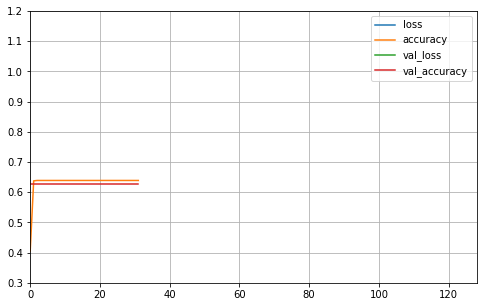

In [363]:
rr.plot()

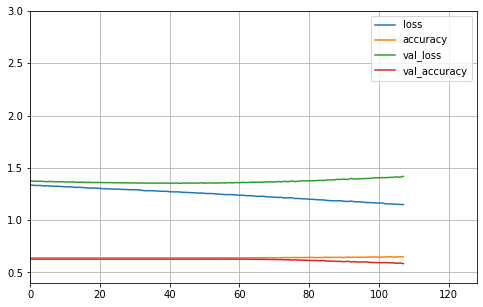

In [366]:
#学習曲線のプロット
pd.DataFrame(rr.history.history).plot(figsize=(8,5))
plt.grid()
plt.gca().set_ylim(0.4,3)
plt.gca().set_xlim(0,128)
plt.show()

In [367]:
y_pred = np.argmax(rr.model.predict(rr.X_test), axis=-1)
#print(y_pred.shape)
print("正解データ")
print(rr.y_test)
print("予測結果データ")
print(y_pred)
#print(model.predict(X_test))

正解データ
[4 0 3 ... 1 0 0]
予測結果データ
[0 0 0 ... 0 0 0]


In [368]:
pd.DataFrame(y_pred).value_counts()

0    13991
dtype: int64

In [369]:
pd.DataFrame(rr.y_test).value_counts()

0    8810
1    1037
2    1037
4    1037
3    1036
5    1034
dtype: int64

In [279]:
pd.DataFrame(rr.y_test)

,0
0,4
1,0
2,3
3,0
4,0
...,...
13986,5
13987,0
13988,1
13989,0


In [280]:
pd.DataFrame(y_pred)

,0
0,1
1,0
2,0
3,0
4,0
...,...
13986,0
13987,0
13988,0
13989,0


In [ ]:
ばちい　増やす　さげる -
えぽっく　増やす - 
欠損値　埋める -
中関そう　ふやす - 
dropaut 追加 -
aleaystopping 追加 - 
race_id level=0 を削除　もしくわ　カテゴリ変数に直す *
logloss 使ってみる -

In [ ]:
反省点　
日分類で予測を行なった際はラベルの偏りがあったため出力が0に偏った

やること
・1to5 or 0が目的変数の学習を行う
・ラベルの偏りをなくしたデータで学習を行う


In [6]:
r[["rank"]].loc["201901010101"]

,rank
201901010101,1
201901010101,0
201901010101,1
201901010101,1
201901010101,0
201901010101,0
201901010101,0
201901010101,0
201901010101,0


In [7]:
r[["rank"]].value_counts()

rank
0       36759
1       10359
dtype: int64